# GRAD-E1426 Network Analysis: Assignment 2 
#### Janine De Vera, 219848

## Characterizing the Depth and Scope of Trade Agreements

Over the last half century the world has seen historic changes in the international trade landscape, marked by increasing fragmentation of production processes through global value chains and deepening of trade relations through **preferential trade agreements (PTAs)**. Based on the World Trade Organization's (WTO) database, the number of trade agreements in force grew seven-fold from 50 in 1990 to 355 in 2022. 

The sharp rise in trade agreements sparked a new research interest in the depth and scope of their contents. Before the mid 1990s, PTAs mostly invovled provisions for market access and preferential tariffs. In the last 30 years new forms of cooperation have spread and trade agreements have become deeper, making room for provisions outside the scope of the WTO mandate such as data protection, intellectual property, human rights, and environmental laws. 

This exercise provides a descriptive analysis of trade agreement networks, focusing on characteritizing how the scope of agreements have changed over time and identifying key actors (i.e. economies) that drive network dynamics. 

In [1]:
import graph_tool.all as gt
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.pyplot import clf, xlabel, ylabel, imshow, colorbar, savefig
import pandas as pd
import numpy as np
import os
import math


In [2]:
os.getcwd()

'/Users/janinedevera/Documents/School/MDS 2021-2023/Semester 4/2 Network Analysis/Assignments/network-analysis-trade-agreements/code'

## I. Data

For this analysis, I use World Bank's <a href="https://datatopics.worldbank.org/dta/table.html"> *Horizontal Trade Agreements Database*</a>. This dataset contains preferential trade agreements (PTAs) notified to the World Trade Organization as of 2015. For each agreement the following variables are provided: trade partners, year of enforcement, PTA type, indicators of presence (or absence) of 52 PTA provisions, and legal enforceability of each provision. All information is recorded bilaterally, as seen below. 

There are two main types of provisions - _**wto_plus**_ and _**wto_x**_. The former includes PTA provisions under the mandate of the WTO. This includes anti-dumping policies, customs duties and export taxes. The latter, _**wto_x**_ (WTO extra), pertains to provisions outside the mandate of the WTO such as consumer protection, environmental laws, cultural cooperation, and immigration policies.

The _**depth**_ variable measures the depth or scope of a trade agreement by summing the number of key PTA provisions that appear in a particular agreement. The maximum possible value is 52. Similarly, the _**depth_le**_ variable is a measure of depth and scope, but only includes legally enforceable provisions. 

In [3]:
pta = pd.read_excel("../data/WB_Bilateral PTAs_2018.xlsx")

In [4]:
pta['depth'] = pta.filter(regex=r'^wto(?!.*_le$)').sum(axis=1)
pta['depth_le'] = pta.filter(regex=r'^wto.*_le$').sum(axis=1)
pta.head()

cty1 iso1     cty2 iso2  year agreement  entry_force type   
0  Angola  AGO  Burundi  BDI  1994    COMESA         1994   CU  \
1  Angola  AGO  Burundi  BDI  1995    COMESA         1994   CU   
2  Angola  AGO  Burundi  BDI  1996    COMESA         1994   CU   
3  Angola  AGO  Burundi  BDI  1997    COMESA         1994   CU   
4  Angola  AGO  Burundi  BDI  1998    COMESA         1994   CU   

   wto_plus_ftaindustrial  wto_plus_ftaagriculture  ...   
0                       1                        1  ...  \
1                       1                        1  ...   
2                       1                        1  ...   
3                       1                        1  ...   
4                       1                        1  ...   

   wto_X_regionalcooperation_le  wto_X_researchandtechnology_le  wto_X_sme_le   
0                             0                               0             0  \
1                             0                               0             0   
2                             0                               0             0   
3                             0                               0             0   
4                             0                               0             0   

   wto_X_socialmatters_le  wto_X_statistics_le  wto_X_taxation_le   
0                       0                    0                  0  \
1                       0                    0                  0   
2                       0                    0                  0   
3                       0                    0                  0   
4                       0                    0                  0   

   wto_X_terrorism_le  wto_X_visaandasylum_le  depth  depth_le  
0                   0                       0     29        22  
1                   0                       0     29        22  
2                   0                       0     29        22  
3                   0                       0     29        22  
4                   0                       0     29        22  

[5 rows x 114 columns]

<a href="https://www.sciencedirect.com/science/article/abs/pii/S2214312216300138?via%3Dihub">Limao (2016)</a> categorises the 52 key PTA provisions into 9 groups - (i) import tariffs, (ii) non-tariff barriers, (iii) behind the border policies, (iv) other policies, (v) services, (vi) technology, (vii) investment/capital, (viii) labor, and (ix) non-economic policies.

For the exploratory data analysis in later sections, I create 2 additional indicator variables - a variable for whether an agreement contains at least one legally enforceable WTO-extra provision and another for whether an agreement contains at least one legally enforceable non-economic policy. The provisions included in the latter are environmental laws, audiovisual cooperation, cultural cooperation, health, human rights, illicit drugs, money laundering, political dialogue, and terrorism. 

In [7]:
# indicator variable for wto_x_le
pta['wto_x_le'] = 0
for column in pta.columns:
    if "wto_X" in column and "_le" in column:
        pta['wto_x_le'] = pta['wto_x_le'] | (pta[column] > 0)
pta['wto_x_le'] = pta['wto_x_le'].astype(int)

# indicator variable for wto_x_nonecon
non_econ = ['wto_X_environmentallaws_le', 'wto_X_audiovisual_le', 'wto_X_culturalcooperation_le', 'wto_X_health_le', 'wto_X_humanrights_le', 
            'wto_X_illicitdrugs_le', 'wto_X_moneylaundering_le', 'wto_X_politicaldialogue_le', 'wto_X_terrorism_le', ]
pta['wto_x_nonecon'] = 0
for column in pta.columns:
    if column in non_econ:
        pta['wto_x_nonecon'] = pta['wto_x_nonecon'] | (pta[column] > 0)
pta['wto_x_nonecon'] = pta['wto_x_nonecon'].astype(int)

The dataset is also supplemented with other country-level information such as broad geographic region, economy size, and income classification.

In [8]:
regions = pd.read_excel("../data/WB_regions.xls", skiprows=4, index_col=0)
regions = regions[['Economy', 'Code', 'Region_Clean', 'Income group']].dropna(subset = ['Region_Clean'])

Economy Code                Region_Clean         Income group
x                                                                      
1     Afghanistan  AFG                  South Asia           Low income
2         Albania  ALB                      Europe  Upper middle income
3         Algeria  DZA  Middle East & North Africa  Lower middle income
4  American Samoa  ASM         East Asia & Pacific  Upper middle income
5         Andorra  AND                      Europe          High income

In [10]:
economy = pd.read_excel("../data/WB_economy.xlsx", skiprows = 4)
economy = economy.iloc[:, [1, -1]].rename(columns={economy.columns[-1]: 'gva'})

Country Code           gva
0          ABW           NaN
1          AFE           NaN
2          AFG  1.178349e+12
3          AFW           NaN
4          AGO  4.461294e+13

The final merged dataset _**trade_df**_ is constructed such that each observation is a unique country-pair agreement.

In [12]:
# merge datasets
trade_df = pd.merge(pta, regions, left_on='iso1', right_on='Code')
trade_df = pd.merge(trade_df, economy, left_on='iso1', right_on='Country Code')

In [13]:
# remove duplicate pairs
trade_df['sorted_iso'] = trade_df[['iso1', 'iso2']].apply(lambda x: tuple(sorted(x)), axis=1) # country-pair tuple
trade_df = trade_df.drop_duplicates(subset=['sorted_iso', 'agreement'], keep='first')
trade_df.head()

cty1 iso1                          cty2 iso2  year   
0   Angola  AGO                       Burundi  BDI  1994  \
14  Angola  AGO                      Botswana  BWA  2000   
30  Angola  AGO  Democratic Republic of Congo  COD  1994   
36  Angola  AGO  Democratic Republic of Congo  COD  2000   
60  Angola  AGO                       Comoros  COM  1994   

                                 agreement  entry_force type   
0                                   COMESA         1994   CU  \
14  Southern African Development Community         2000  FTA   
30                                  COMESA         1994   CU   
36  Southern African Development Community         2000  FTA   
60                                  COMESA         1994   CU   

    wto_plus_ftaindustrial  wto_plus_ftaagriculture  ...  depth_le  wto_x_le   
0                        1                        1  ...        22         1  \
14                       1                        1  ...        20         0   
30                       1                        1  ...        22         1   
36                       1                        1  ...        20         0   
60                       1                        1  ...        22         1   

    wto_x_nonecon  Economy  Code        Region_Clean         Income group   
0               0   Angola   AGO  Sub-Saharan Africa  Lower middle income  \
14              0   Angola   AGO  Sub-Saharan Africa  Lower middle income   
30              0   Angola   AGO  Sub-Saharan Africa  Lower middle income   
36              0   Angola   AGO  Sub-Saharan Africa  Lower middle income   
60              0   Angola   AGO  Sub-Saharan Africa  Lower middle income   

    Country Code           gva  sorted_iso  
0            AGO  4.461294e+13  (AGO, BDI)  
14           AGO  4.461294e+13  (AGO, BWA)  
30           AGO  4.461294e+13  (AGO, COD)  
36           AGO  4.461294e+13  (AGO, COD)  
60           AGO  4.461294e+13  (AGO, COM)  

[5 rows x 123 columns]

## II. Network Plots

To visualize the trade agreements network, the data first has to be structured in a way that is compatible with the _**Graph()**_ class of graph-tool. I create a list of unique countries which will serve as nodes and country-pair agreements which will serve as edges. The network is designed such that if two countries have more than one PTA with each other, there will also be more than one link between them. Country name and pair name properties for nodes and edges are also added for ease of reference.

### A. Creating *graph* object

In [14]:
# unique countries and country pair agreements
nodes = trade_df['iso1'].drop_duplicates()
pairs = trade_df[['iso1', 'iso2', 'agreement']].drop_duplicates(keep='first')

# edge pairs as list of tuples 
pairs = list(zip(pairs.iso1, pairs.iso2))

In [15]:
# instantiate undirected Graph object
trade_graph = gt.Graph(directed=False)

In [16]:
# add nodes and edges from pairs list, create country_name and pair_name as properties
country_name = trade_graph.new_vertex_property('string')
pair_name = trade_graph.new_edge_property('object')

node_list = {}
for pair in pairs:
    for name in pair:
        if name not in node_list:
            v = trade_graph.add_vertex() #add vertex 
            node_list[name] = v #add vertex index to node dict
            country_name[v] = name #add name of vertex index as property
    e = trade_graph.add_edge(node_list[pair[0]], node_list[pair[1]]) #add edge
    pair_name[e] = (pair[0], pair[1]) #add name of pair index as property

trade_graph.vertex_properties["country_name"] = country_name
trade_graph.edge_properties["pair_name"] = pair_name

In [27]:
# network layout: position of nodes 
pos = gt.sfdp_layout(trade_graph)

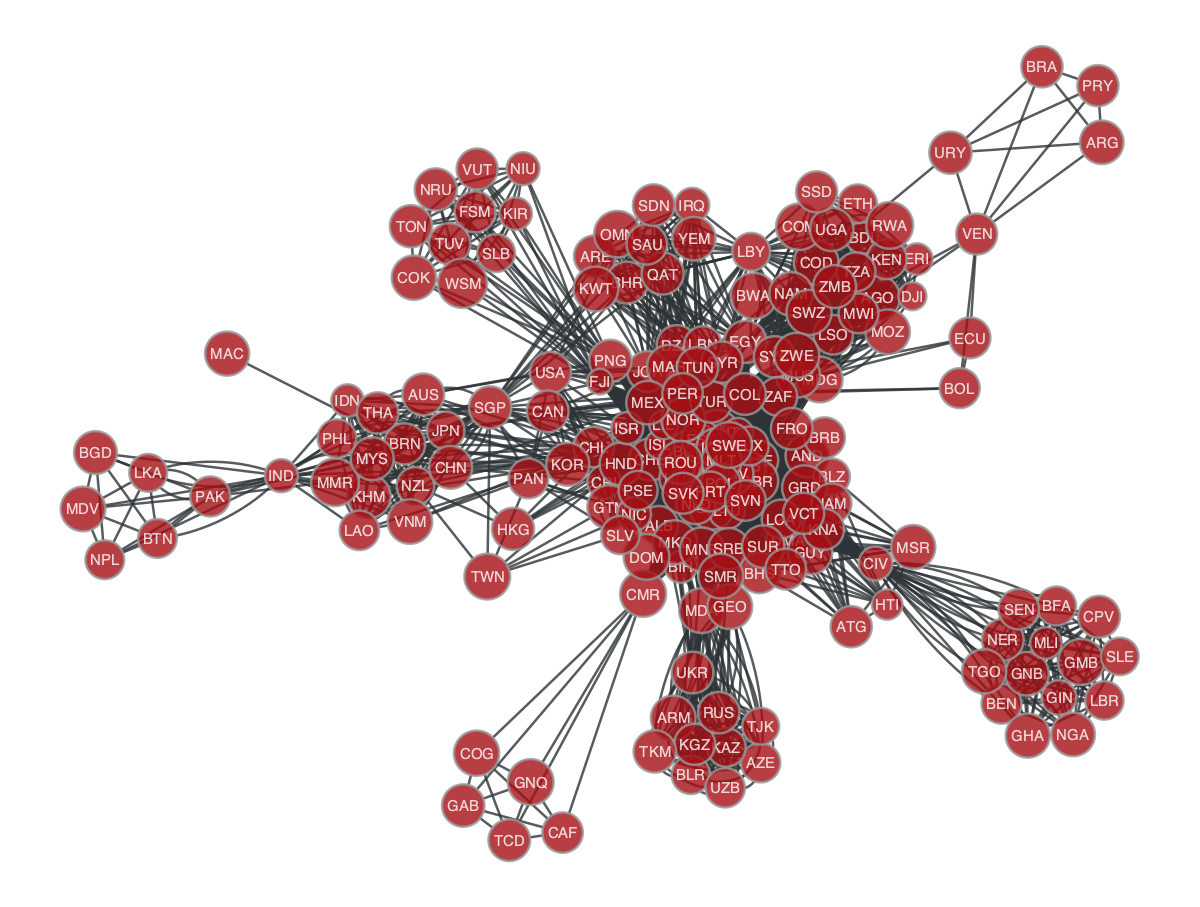

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x29b8117c0, at 0x29c415040>

In [28]:
gt.graph_draw(trade_graph, pos = pos, vertex_text = country_name, vertex_font_family='sans serif')

### B. Node and edge properties

Other country-level and agreement-level information can also be added as node and edge properties. They can be used to further customize the network visualization and create sub-networks. I added the following properties to the trade agreements network: 

* **Node color**: country's geographical region
* **Edge weight**: PTA depth 
* **Edge color**: whether an agreement contains non-economic provisions 
* **Edge filter**: year when agreement was enforced 


#### i. Nodes

In [29]:
def add_node_property(node_property_type, dictionary):
    node_property = trade_graph.new_vertex_property(node_property_type)

    for v in trade_graph.vertices():
        name = trade_graph.vp.country_name[v]
        if name in dictionary:
            node_property[v] = dictionary[name]
        else:
            trade_graph.remove_vertex(v)
    return node_property

*Node color: region*

In [30]:
# list of unique country names and corresponding region
country1 = trade_df[['iso1']]
country2 = trade_df[['iso2']].rename(columns={'iso2': 'iso1'})

countries_all = pd.concat([country1, country2], ignore_index = True).drop_duplicates(keep='first')
countries_all = pd.merge(countries_all, regions, left_on='iso1', right_on='Code')[['iso1', 'Region_Clean']]

In [31]:
# region-color dictionary  
region_colors = {'Sub-Saharan Africa':'#FA9265', # orange
                 'Europe': '#7ACCE1', # blue
                 'Middle East & North Africa': '#FA9265', # orange
                 'Latin America & Caribbean': '#90BC62', # green
                 'East Asia & Pacific': '#C7448C', # pink
                 'Central Asia': '#C7448C', # pink
                 'South Asia': '#C7448C', # pink
                 'North America': '#A68FC7'} # purple

# map colors to regions
countries_all['region_colors'] = countries_all['Region_Clean'].map(region_colors)

# node color dictionary
node_color_dict = (
    countries_all[['iso1', 'region_colors']]
    .drop_duplicates()
    .set_index('iso1')
    .to_dict()['region_colors']
    )

In [32]:
node_color = add_node_property('string', node_color_dict)
trade_graph.vertex_properties["node_color"] = node_color

*Node filter: region*

In [33]:
# node region dictionary
node_region_dict = (
    countries_all[['iso1', 'Region_Clean']]
    .drop_duplicates()
    .set_index('iso1')
    .to_dict()['Region_Clean']
    )

In [34]:
node_region = add_node_property('string', node_region_dict)
trade_graph.vertex_properties["node_region"] = node_region

#### ii. Edges

In [35]:
def add_edge_property(edge_property_type, dictionary, default_val=0):
    edge_property = trade_graph.new_edge_property(edge_property_type)
    for e in trade_graph.edges():
        name = trade_graph.ep.pair_name[e]
        if name in dictionary:
            edge_property[e] = dictionary[name]
        else:
            edge_property[e] = default_val  # set default value if not found in the dictionary
    return edge_property

*Edge weight: depth of trade agreements*

In [36]:
# define edge weight dictionary
edge_size_dict = (
    trade_df[['sorted_iso', 'depth_le']]
    .drop_duplicates()
    .set_index('sorted_iso')
    .to_dict()['depth_le']
    )

In [37]:
# add edge property
edge_weight = add_edge_property(edge_property_type='float', dictionary=edge_size_dict, default_val=0)
trade_graph.edge_properties['edge_weight'] = edge_weight

*Edge color: legal enforceability of non-economic provisions*

In [38]:
# agreement-color dictionary  
wto_colors = {1:'#FAEABA', # yellow
              0: '#EBEBEB'} # white

# map colors to agreements
trade_df['wto_colors'] = trade_df['wto_x_nonecon'].map(wto_colors)

# define edge color dictionary
edge_colors_dict = (
    trade_df[['sorted_iso', 'wto_colors']]
    .drop_duplicates()
    .set_index('sorted_iso')
    #.apply(lambda x: {'wto_colors': x['wto_colors'], 'wto_x_nonecon': x['wto_x_nonecon']}, axis=1)
    .to_dict()['wto_colors']
    )

In [39]:
edge_color = add_edge_property(edge_property_type='string', dictionary=edge_colors_dict, default_val='#EBEBEB')
trade_graph.edge_properties['edge_color'] = edge_color

*Edge filter: legal enforceability of non-economic provisions*

In [40]:
# define edge color dictionary
edge_nonecon_dict = (
    trade_df[['sorted_iso', 'wto_x_nonecon']]
    .drop_duplicates()
    .set_index('sorted_iso')
    .to_dict()['wto_x_nonecon']
    )

In [41]:
edge_nonecon_prov = add_edge_property(edge_property_type='float', dictionary=edge_nonecon_dict, default_val=0)
trade_graph.edge_properties['edge_nonecon_prov'] = edge_nonecon_prov

*Edge filter: year agreement entry in force*

In [42]:
# define year dictionary
edge_year_dict = (
    trade_df[['sorted_iso', 'entry_force']]
    .drop_duplicates()
    .set_index('sorted_iso')
    .to_dict()['entry_force']
    )

In [43]:
edge_year= add_edge_property(edge_property_type='int', dictionary=edge_year_dict, default_val=0)
trade_graph.edge_properties['edge_year'] = edge_year

### C. Plot network

Below is a network of preferential trade agreements notified to the WTO as of 2015. Countries are represented as nodes and are colored according to their regions. Nodes are linked together if two countries are signatories to the same trade agreement, regardless of whether the agreement is bilateral or multilateral. The edges are weighted by the depth of the agreement and are highlighted when the agreement involves provisions that are non-economic in nature (i.e. environmental, cultural, politcal, etc).

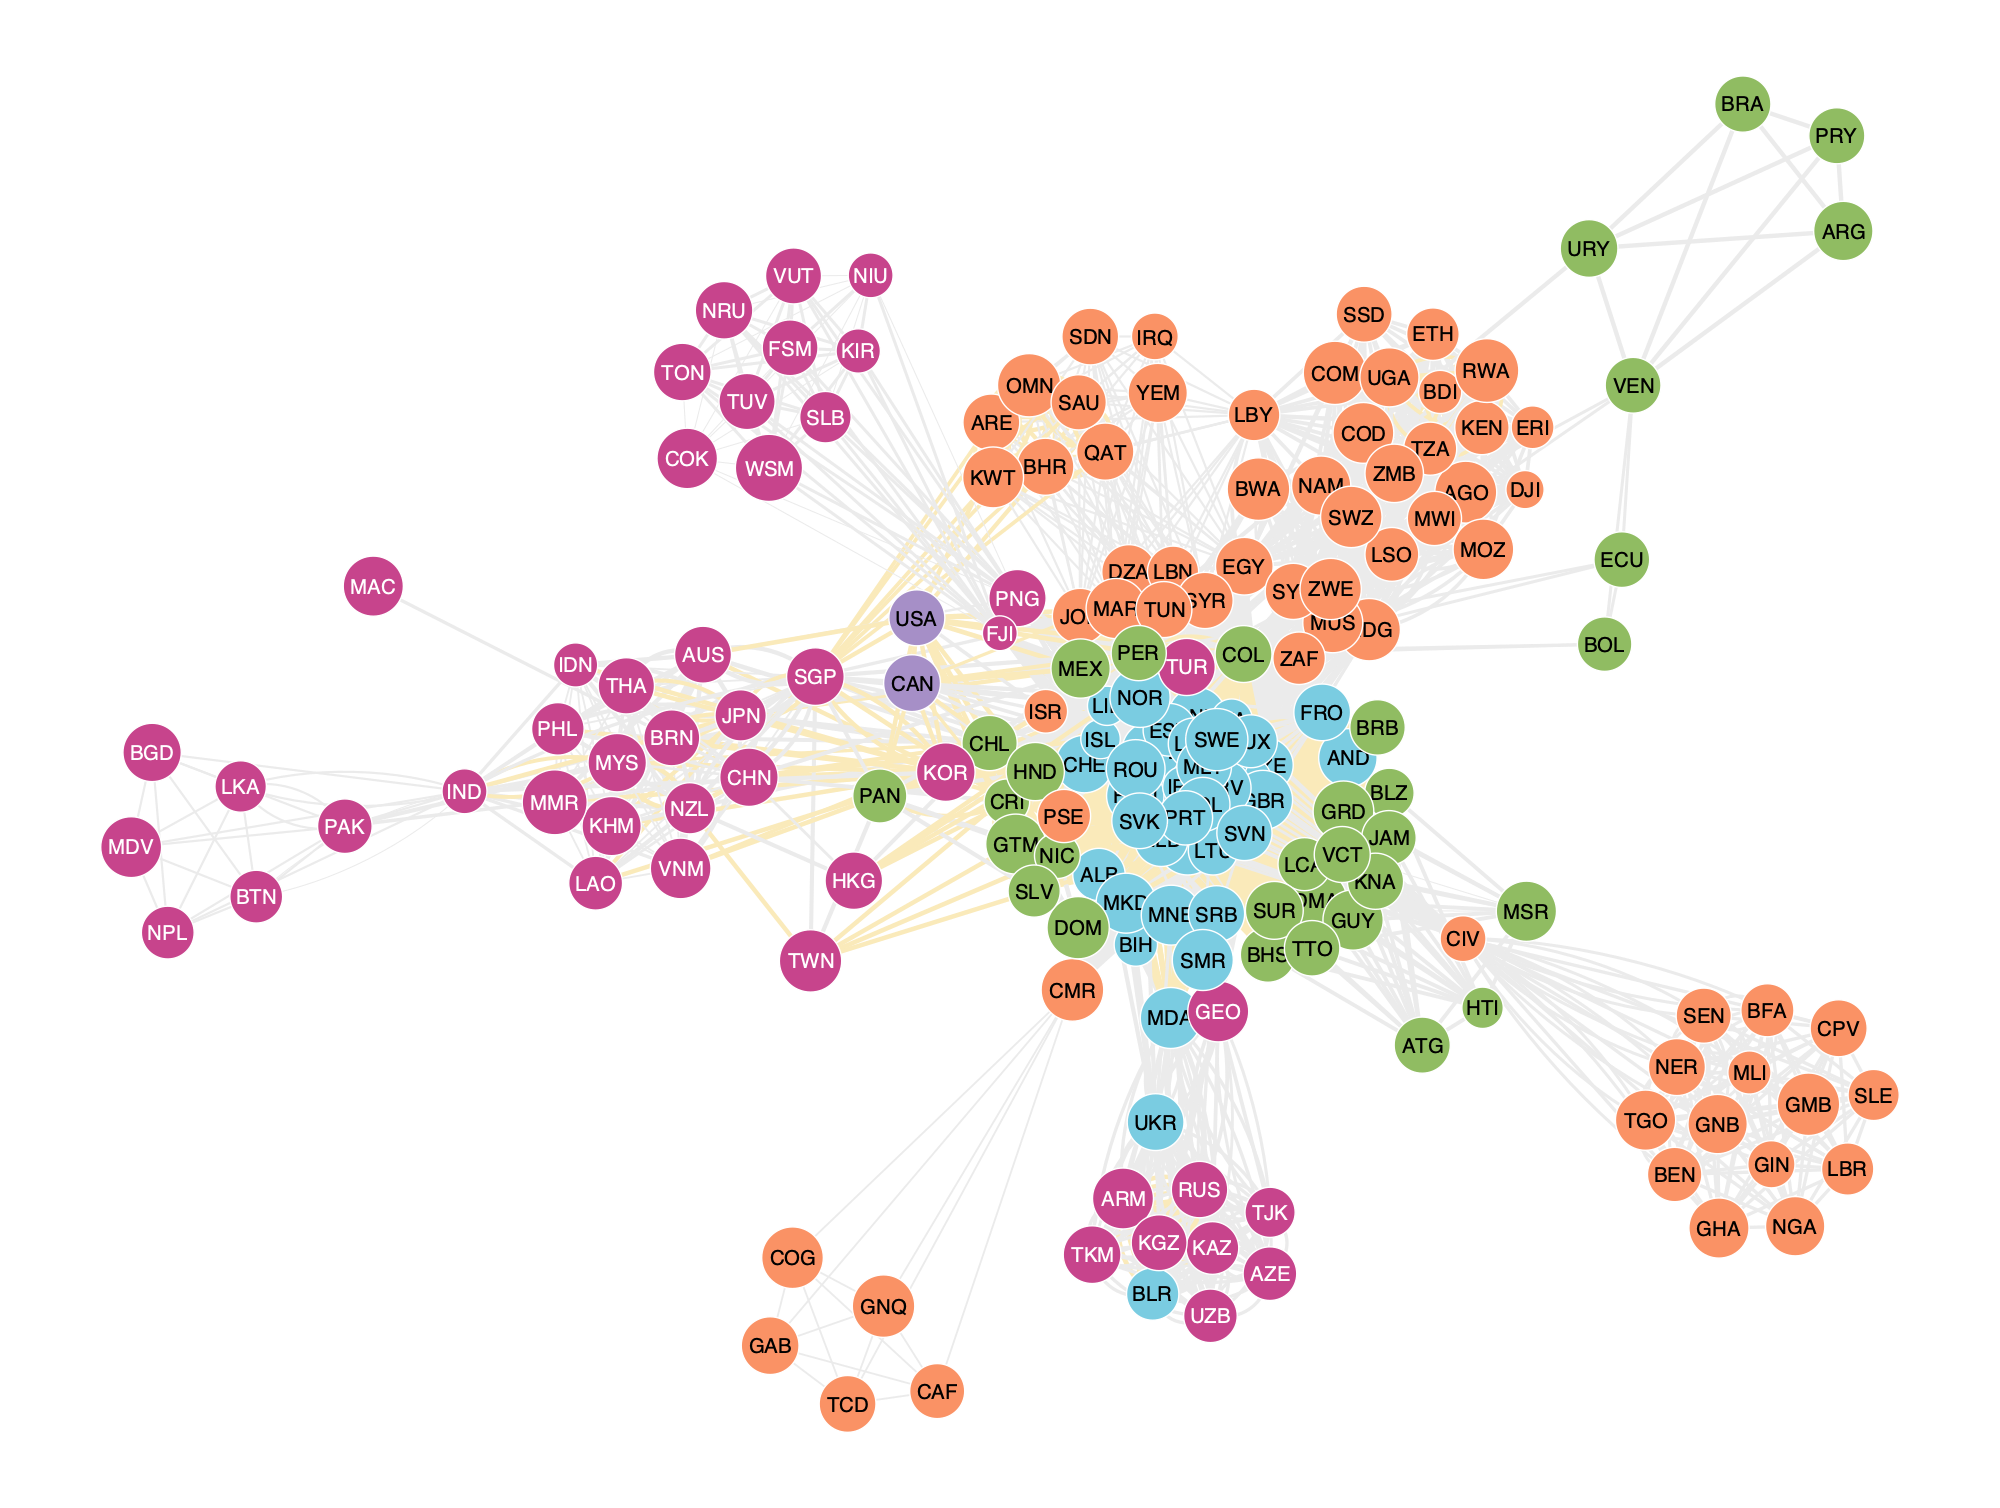

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x29b8117c0, at 0x2870890d0>

In [54]:
gt.graph_draw(trade_graph, pos=pos, 
    vertex_fill_color=node_color, 
    vertex_size=17, 
    vertex_color='#FFFFFF',
    vertex_pen_width=0.7,
    vertex_anchor=0,
    vertex_font_family='sans serif',
    vertex_text=country_name,
    edge_color=edge_color,
    edge_pen_width=gt.prop_to_size(edge_weight, mi=0.5, ma=3),
    output_size=(1000,1000))
    #output="../charts/trade_complete.png")

As expected, the graph shows a clustering of countries by region, indicating that economies that are geographically closer tend to be involved in the same agreements. European countries appear to be the most dense and central set of nodes. They are also closely linked with Latin American countries. Collectively, the countries forming the Community of Latin American and Caribbean States (CELAC) are the EU's fifth largest trading partner <a href="https://www.europarl.europa.eu/RegData/etudes/IDAN/2019/644219/EPRS_IDA(2019)644219_EN.pdf">(European Parliament, 2019)</a>. The EU has both multiparty and bilateral agreements with several Latin American groupings and their individual members (e.g. CARIFORUM, Central American Group). Interestngly, MERCOSUR (Southern Common Market) composed of Argentina, Brazil, Paraguay, and Uruguay are isolated from the rest of the Latin American economies. 

Within Asia, clusters are formed by ASEAN countries, Pacific nations, and former Soviet economies. Meanwhile, Middle East and Africa form 3 separate clusters - South African, Central African, East African and Middle Eastern. NAFTA members USA and Canada are close to the center with connections to Asian and Latin American countries. 

Based on the edges, only countries close to the center, specifically Europe, USA, Canada, and a specific set of Asian and Latin American economies are part of trade agreements that deal with non-economic issues and policies.

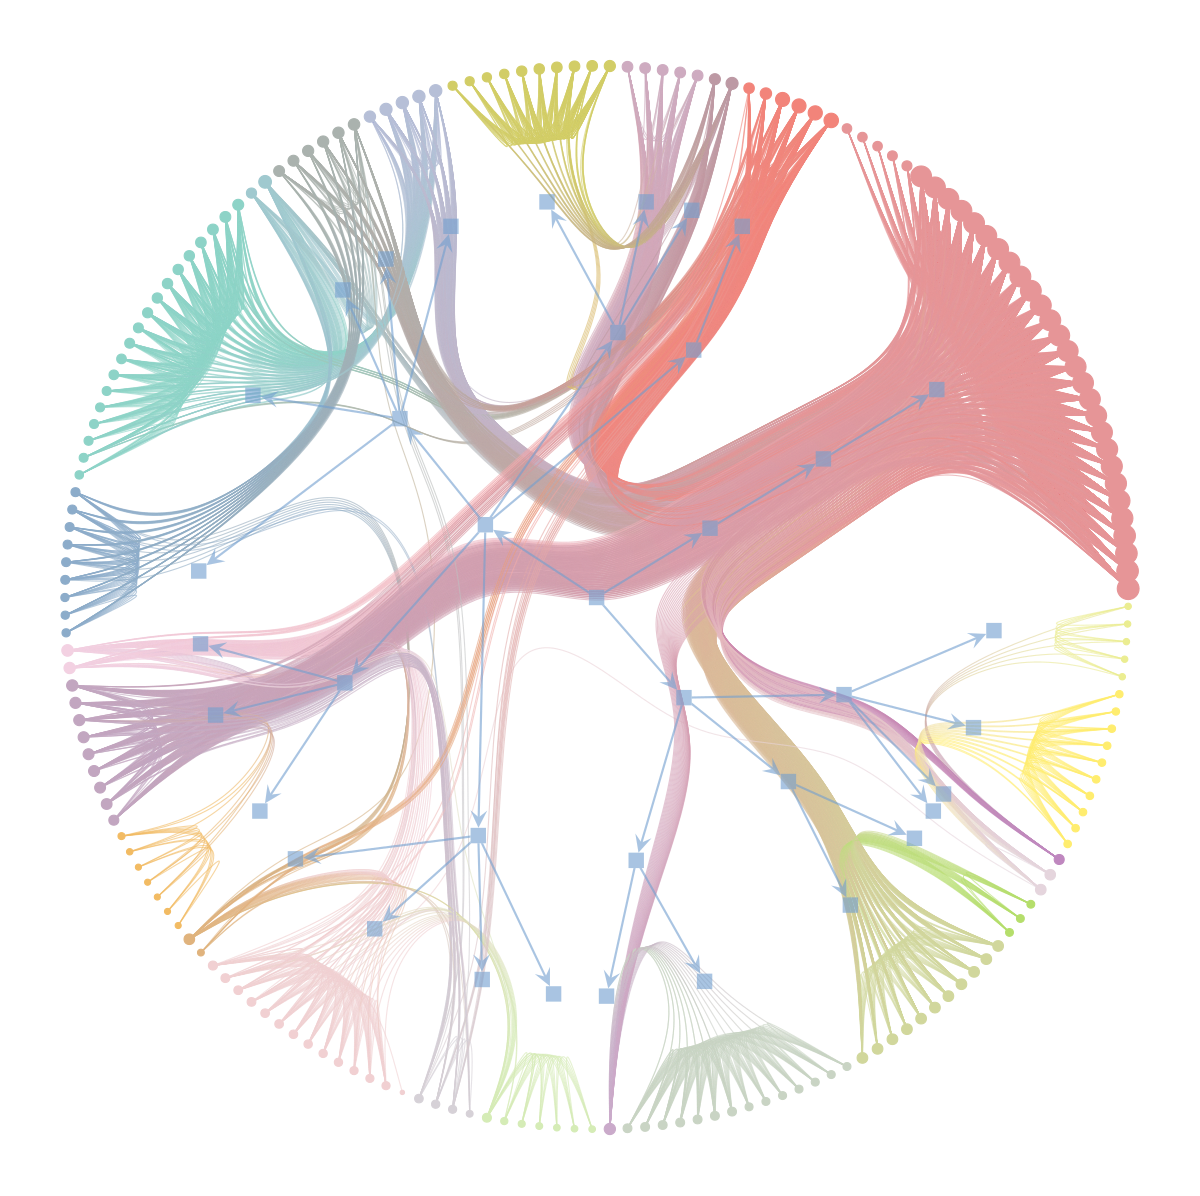

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x168ce8d30, at 0x169860fa0>,
 <GraphView object, directed, with 227 vertices and 226 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x1696495e0, at 0x168d48580>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x1696495e0, at 0x168d48310>, False), at 0x1696495e0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x1696495e0, at 0x168d486a0>)

In [260]:
state = gt.minimize_nested_blockmodel_dl(trade_graph)
state.draw()

## III. Sub Graphs

It is also interesting to examine how the network differs across time and different groups. To do this, I prune the originl network to create several subgraphs that satisfy the given edge filters. 

In [132]:
def create_subgraph(main_graph, filter, largest=False):
    sub = gt.GraphView(main_graph, efilt=filter)

    if largest: # if true get larget connected component only 
        sub = gt.extract_largest_component(sub, prune=True)
    else:
        sub = gt.Graph(sub, prune=True)
        isolated_vertices = [v for v in sub.vertices() if sub.vertex(v).out_degree() == 0 and sub.vertex(v).in_degree() == 0]
        sub.remove_vertex(isolated_vertices, fast=True)

    return sub

### A. By year

_**Trade agreements before 2000**_

As mentioned above, the nature of trade agreements have seen significant changes in the last 30 years. Before 2000, PTAs mostly involved provisions and policies covered by the mandate of the WTO. These policies are primarily economic in nature and are focused on creating open markets to facilitate trade of goods. 

Below I create a sub-network which only contains agreements that came into force before 2000. 

In [133]:
year_filter = trade_graph.new_edge_property("bool")
year_filter.a = trade_graph.ep.edge_year.a < 2000

sg_yr1 = create_subgraph(trade_graph, year_filter)

In [138]:
pos_yr = gt.sfdp_layout(sg_yr1) # network layout 

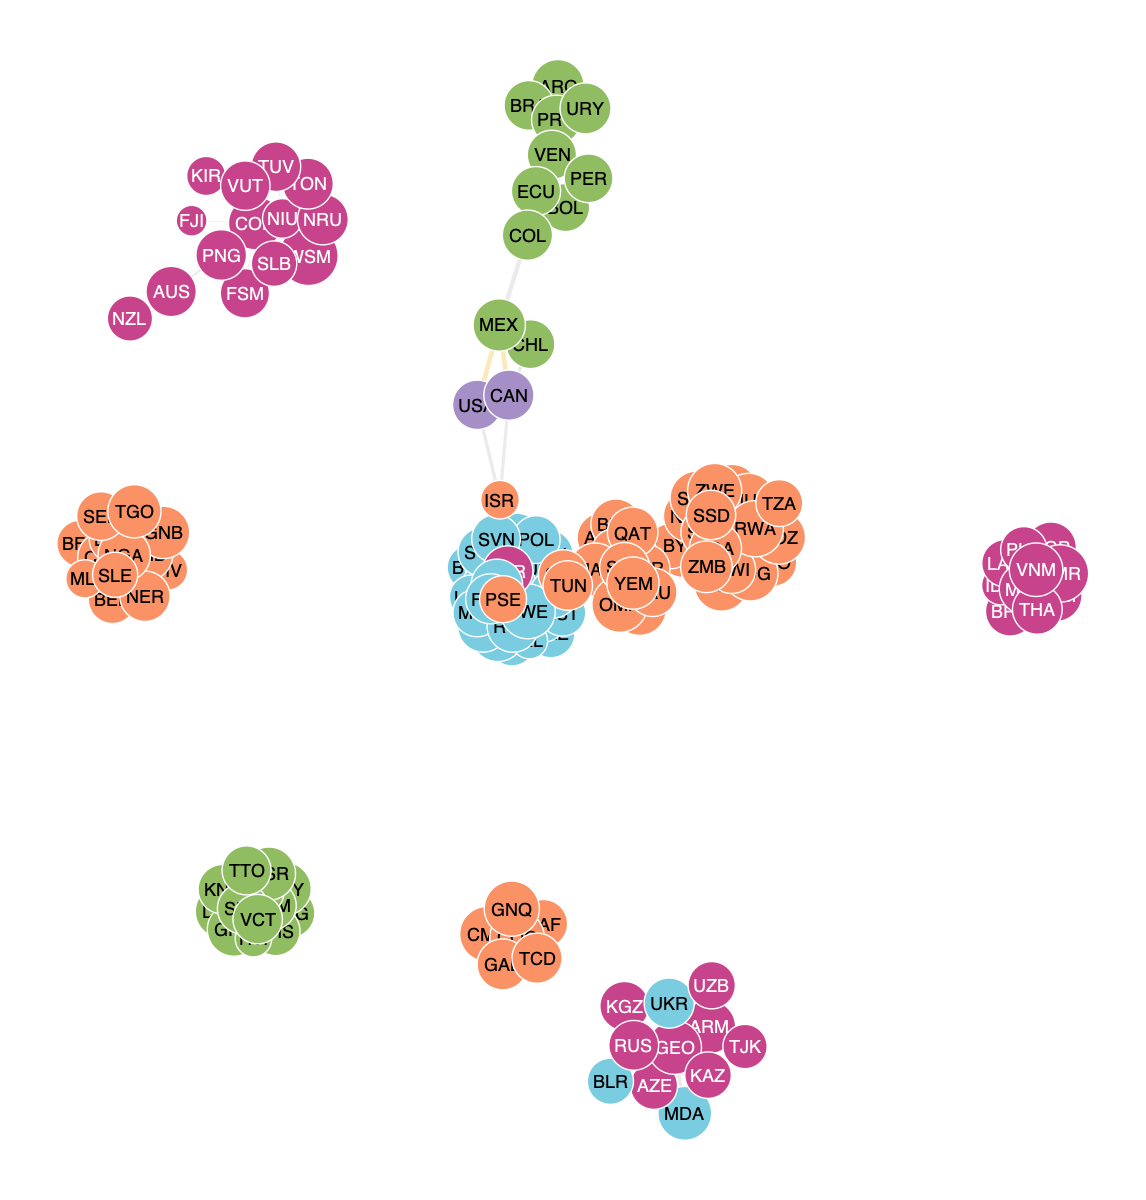

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28bf80190, at 0x28bf95430>

In [165]:
gt.graph_draw(sg_yr1, pos=pos_yr,
            vertex_fill_color=sg_yr1.vp.node_color, 
            vertex_size=15, 
            vertex_text=sg_yr1.vp.country_name, 
            vertex_font_family='sans serif',
            vertex_anchor=0,
            vertex_color='#FFFFFF',
            vertex_pen_width=0.7,
            edge_pen_width=gt.prop_to_size(sg_yr1.ep.edge_weight, mi=0.3, ma=3),
            edge_color=sg_yr1.ep.edge_color)

Pre-millenium PTAs were 

In [70]:
trade_df.loc[(trade_df['Region_Clean'].str.contains("Asia")) & (trade_df['entry_force'] < 2000)]

cty1 iso1        cty2 iso2  year             agreement   
1752         Armenia  ARM  Azerbaijan  AZE  1996                   CIS  \
1770         Armenia  ARM     Belarus  BLR  1994                   CIS   
1792         Armenia  ARM     Georgia  GEO  1994                   CIS   
1797         Armenia  ARM     Georgia  GEO  1998     Georgia - Armenia   
1826         Armenia  ARM  Kazakhstan  KAZ  1994                   CIS   
...              ...  ...         ...  ...   ...                   ...   
149993    Tajikistan  TJK     Ukraine  UKR  1997                   CIS   
150024    Tajikistan  TJK  Uzbekistan  UZB  1997                   CIS   
150278  Turkmenistan  TKM     Ukraine  UKR  1994                   CIS   
150280  Turkmenistan  TKM     Ukraine  UKR  1995  Ukraine-Turkmenistan   
150319  Turkmenistan  TKM  Uzbekistan  UZB  1994                   CIS   

        entry_force type  wto_plus_ftaindustrial  wto_plus_ftaagriculture   
1752           1994  FTA                       1                        1  \
1770           1994  FTA                       1                        1   
1792           1994  FTA                       1                        1   
1797           1998  FTA                       1                        1   
1826           1994  FTA                       1                        1   
...             ...  ...                     ...                      ...   
149993         1994  FTA                       1                        1   
150024         1994  FTA                       1                        1   
150278         1994  FTA                       1                        1   
150280         1995  FTA                       1                        1   
150319         1994  FTA                       1                        1   

        ...  wto_x_le  wto_x_nonecon       Economy  Code  Region_Clean   
1752    ...         0              0       Armenia   ARM  Central Asia  \
1770    ...         0              0       Armenia   ARM  Central Asia   
1792    ...         0              0       Armenia   ARM  Central Asia   
1797    ...         1              0       Armenia   ARM  Central Asia   
1826    ...         0              0       Armenia   ARM  Central Asia   
...     ...       ...            ...           ...   ...           ...   
149993  ...         0              0    Tajikistan   TJK  Central Asia   
150024  ...         0              0    Tajikistan   TJK  Central Asia   
150278  ...         0              0  Turkmenistan   TKM  Central Asia   
150280  ...         1              0  Turkmenistan   TKM  Central Asia   
150319  ...         0              0  Turkmenistan   TKM  Central Asia   

               Income group  Country Code           gva  sorted_iso   
1752    Upper middle income           ARM  6.215676e+12  (ARM, AZE)  \
1770    Upper middle income           ARM  6.215676e+12  (ARM, BLR)   
1792    Upper middle income           ARM  6.215676e+12  (ARM, GEO)   
1797    Upper middle income           ARM  6.215676e+12  (ARM, GEO)   
1826    Upper middle income           ARM  6.215676e+12  (ARM, KAZ)   
...                     ...           ...           ...         ...   
149993           Low income           TJK           NaN  (TJK, UKR)   
150024           Low income           TJK           NaN  (TJK, UZB)   
150278  Upper middle income           TKM           NaN  (TKM, UKR)   
150280  Upper middle income           TKM           NaN  (TKM, UKR)   
150319  Upper middle income           TKM           NaN  (TKM, UZB)   

        wto_colors  
1752       #EBEBEB  
1770       #EBEBEB  
1792       #EBEBEB  
1797       #EBEBEB  
1826       #EBEBEB  
...            ...  
149993     #EBEBEB  
150024     #EBEBEB  
150278     #EBEBEB  
150280     #EBEBEB  
150319     #EBEBEB  

[129 rows x 124 columns]

*Trade agreements after 2000*

In [147]:
year_filter = trade_graph.new_edge_property("bool")
year_filter.a = trade_graph.ep.edge_year.a >= 2000

sg_yr2 = create_subgraph(trade_graph, year_filter, largest=True)

In [160]:
pos_yr2 = gt.sfdp_layout(sg_yr2)

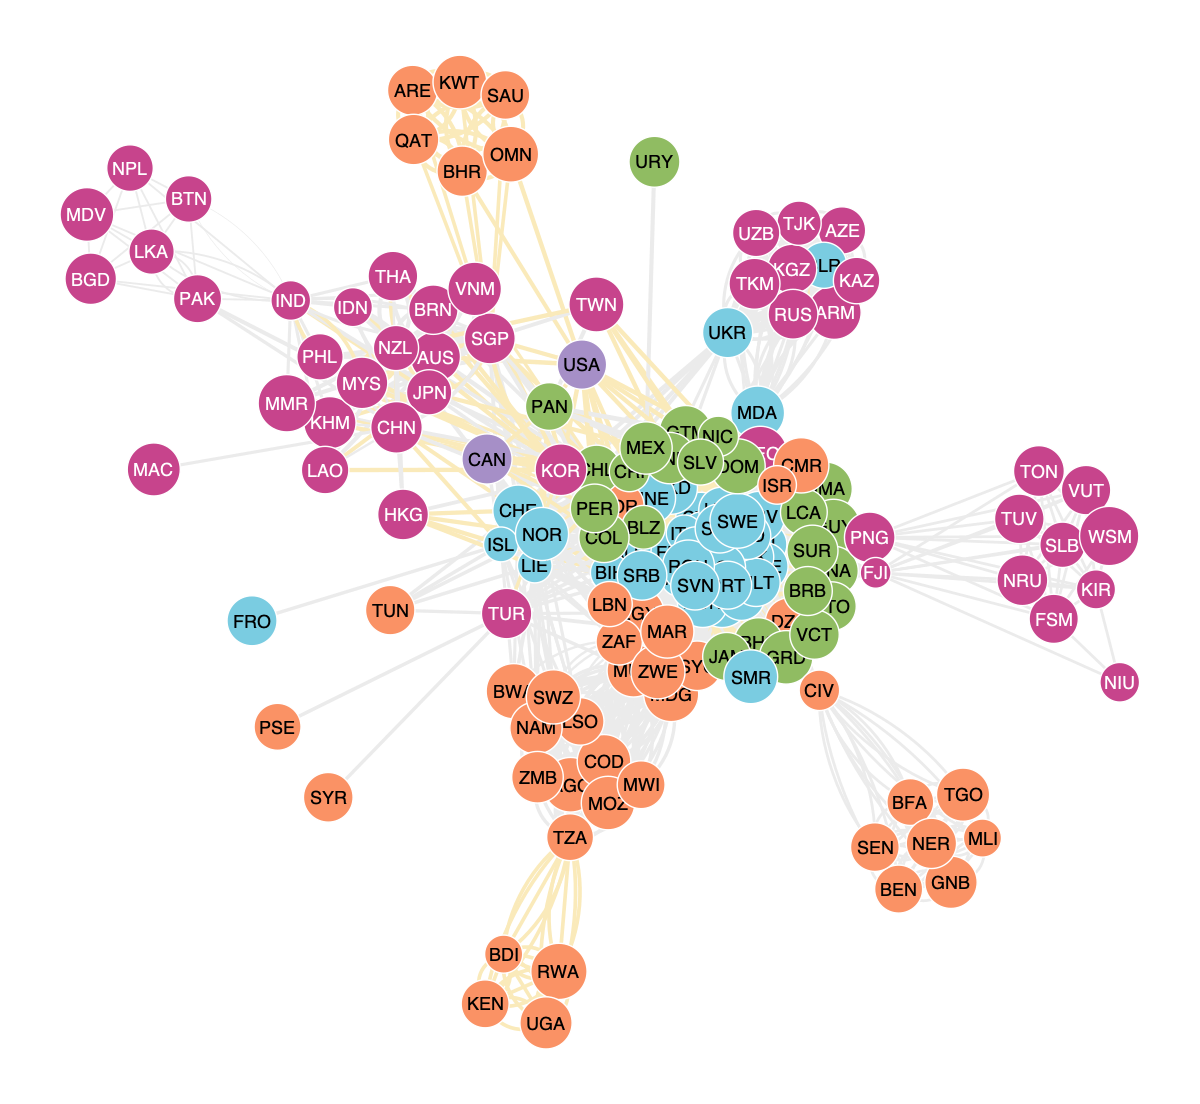

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28bf80040, at 0x28bf88250>

In [164]:
gt.graph_draw(sg_yr2, pos=pos_yr2,
            vertex_fill_color=sg_yr2.vp.node_color, 
            vertex_size=15, 
            vertex_text=sg_yr2.vp.country_name, 
            vertex_font_family='sans serif',
            vertex_anchor=0,
            vertex_color='#FFFFFF',
            vertex_pen_width=0.7,
            edge_pen_width=gt.prop_to_size(sg_yr2.ep.edge_weight, mi=0.3, ma=3),
            edge_color=sg_yr2.ep.edge_color)

### B. By scope

In [166]:
scope_filter = trade_graph.new_edge_property("bool")
scope_filter.a = trade_graph.ep.edge_nonecon_prov.a == 1

sg_nonecon = create_subgraph(trade_graph, scope_filter)

In [172]:
pos_scope = gt.sfdp_layout(sg_nonecon)

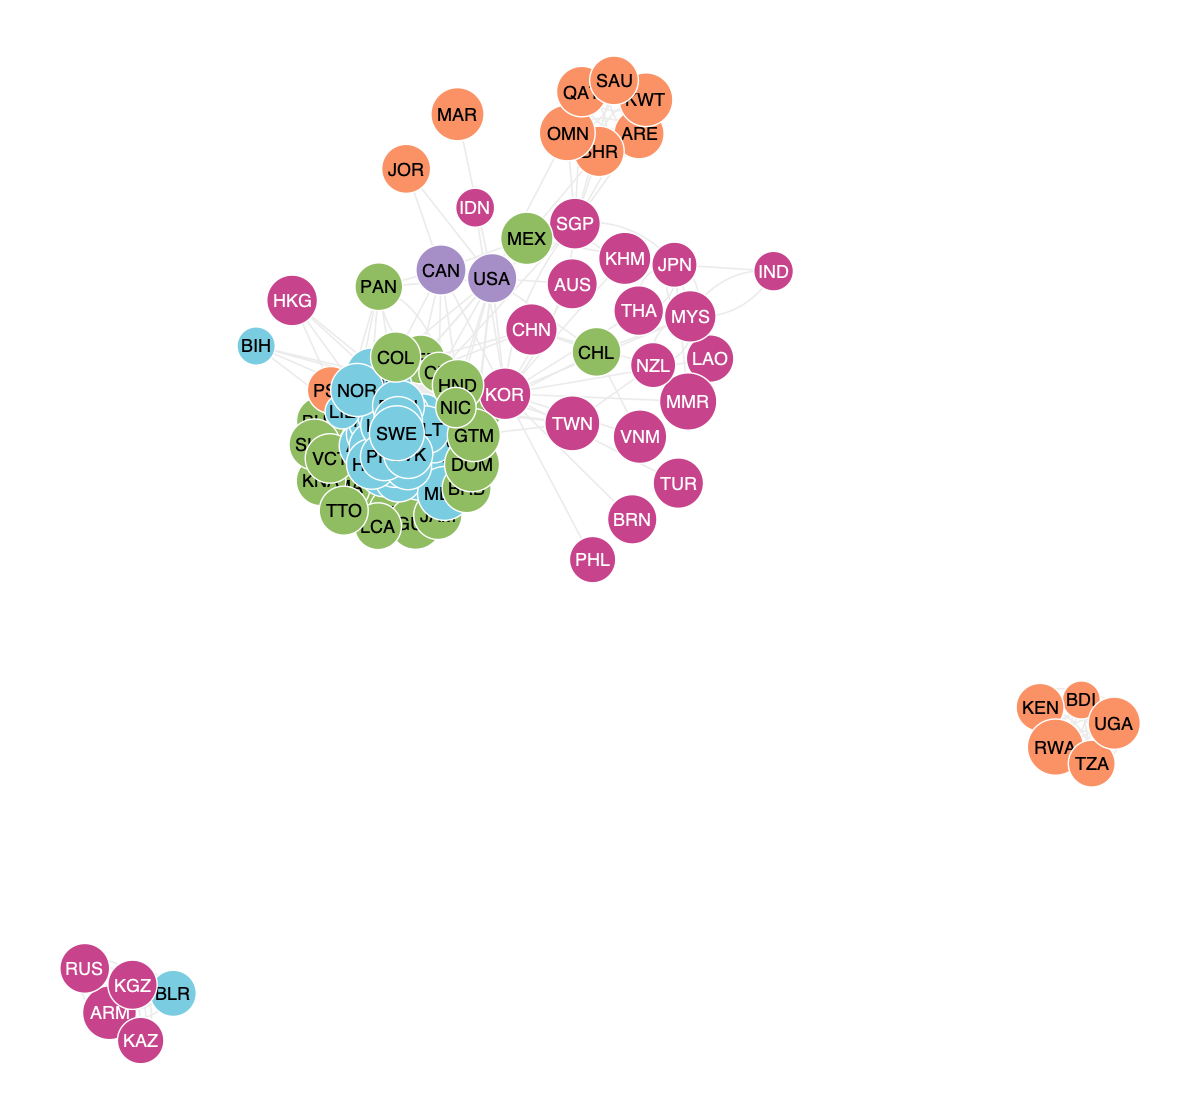

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28bf88df0, at 0x28bfab2e0>

In [175]:
gt.graph_draw(sg_nonecon, pos=pos_scope,
            vertex_fill_color=sg_nonecon.vp.node_color, 
            vertex_size=15, 
            vertex_text=sg_nonecon.vp.country_name, 
            vertex_font_family='sans serif',
            vertex_anchor=0,
            vertex_color='#FFFFFF',
            vertex_pen_width=0.7,
            edge_pen_width=0.8,
            edge_color='#EBEBEB')

## IV. Descriptive Measures

### B. Centrality 

In [176]:
color_map = colors.LinearSegmentedColormap.from_list('color_map', ['#FFFFC9', '#EA683A','#E35934', '#D53C2A', '#C71F1F'])

#### i. Full network

*Eigenvector centrality*

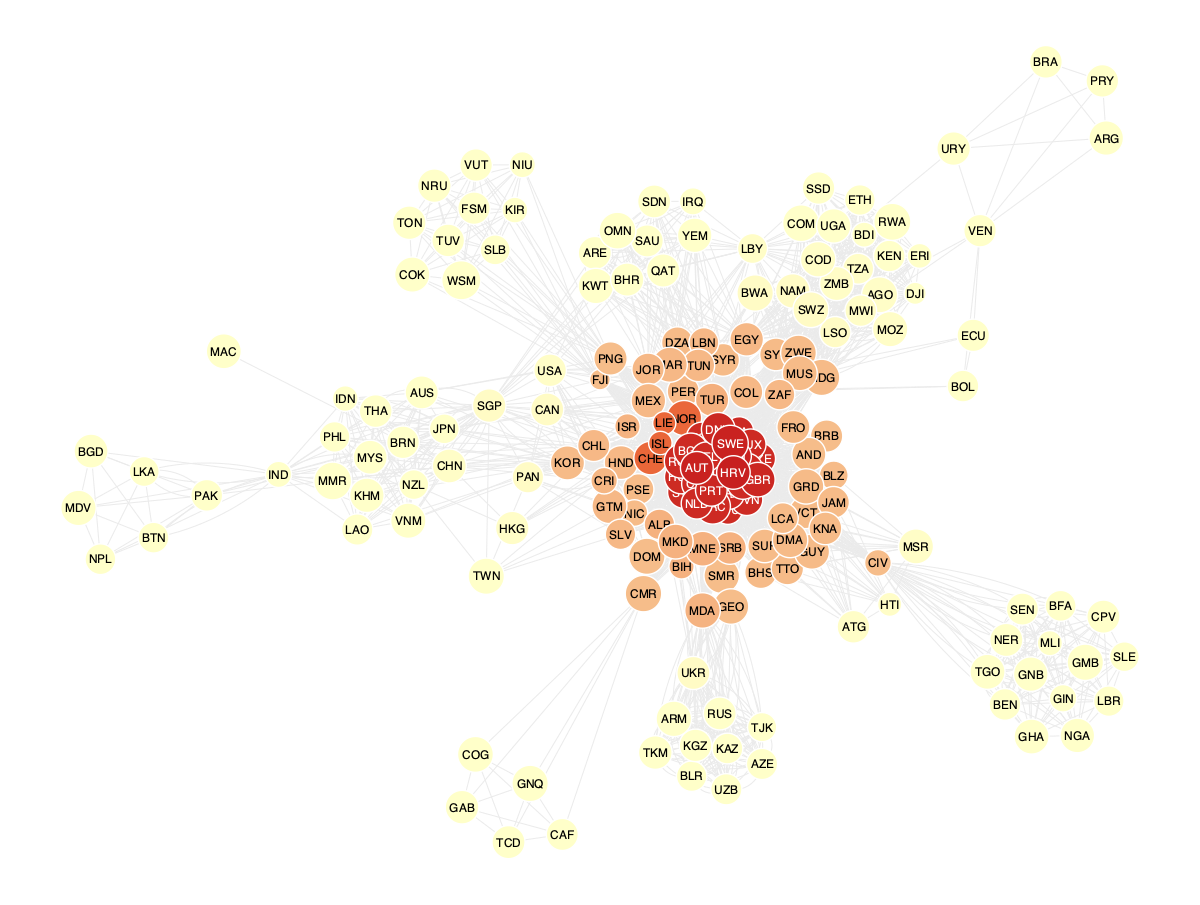

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x29b8117c0, at 0x28bfab1f0>

In [177]:
ee, x = gt.eigenvector(trade_graph)

# network based on centrality
gt.graph_draw(trade_graph, pos=pos, 
              vertex_fill_color=x,
              vertex_size=gt.prop_to_size(x, mi=8, ma=15),
              vcmap=color_map,
              vertex_text=country_name, 
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              edge_color='#EBEBEB',
              vorder=x)


*Betweenness centrality*

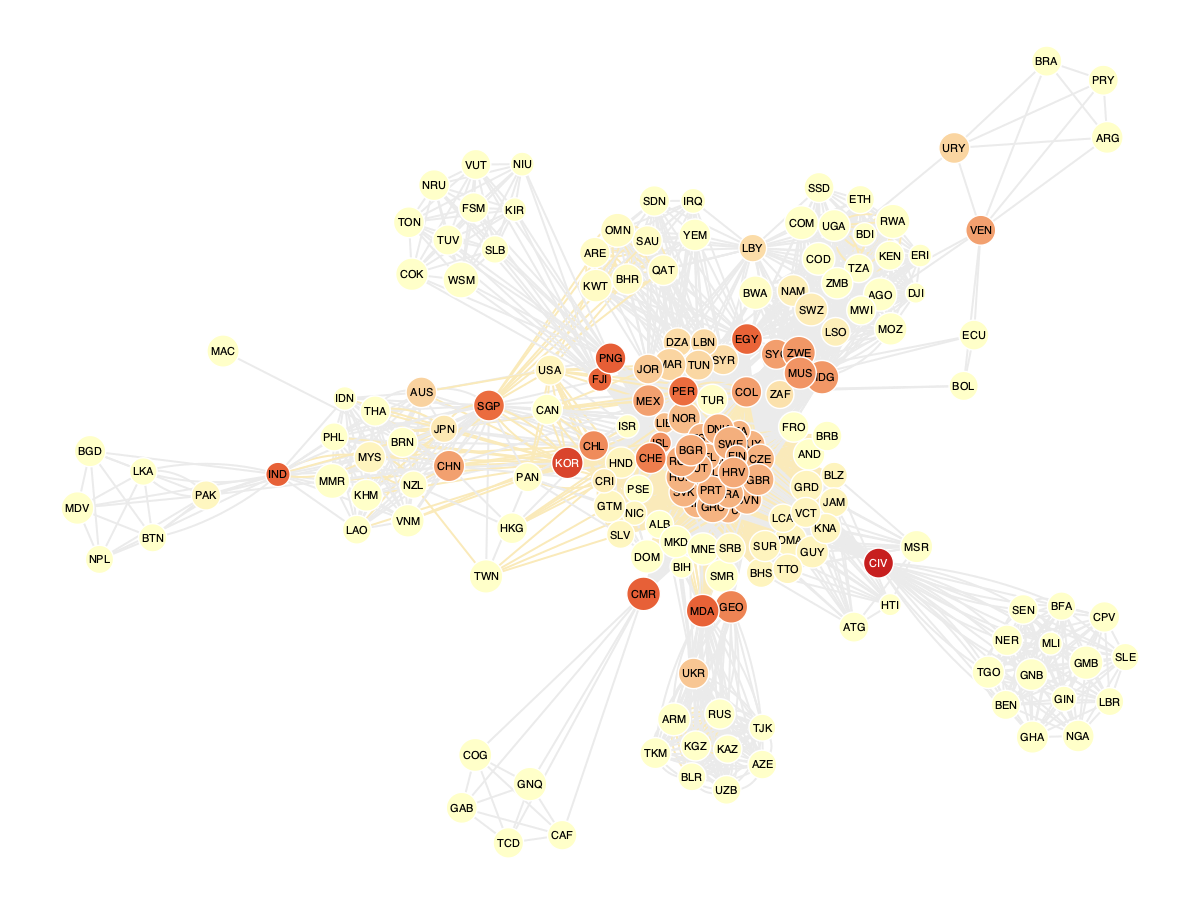

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x29b8117c0, at 0x28bf804f0>

In [178]:
vp, ep = gt.betweenness(trade_graph)
gt.graph_draw(trade_graph, pos=pos, vertex_fill_color=vp,
              vertex_size=gt.prop_to_size(vp, mi=8, ma=15),
              #edge_pen_width=gt.prop_to_size(ep, mi=0.5, ma=5),
              edge_color=edge_color,
              vcmap=color_map,
              vertex_text=country_name, 
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              vorder=vp)

#### ii. Agreements with non-economic provisions

*Eigenvector centrality*

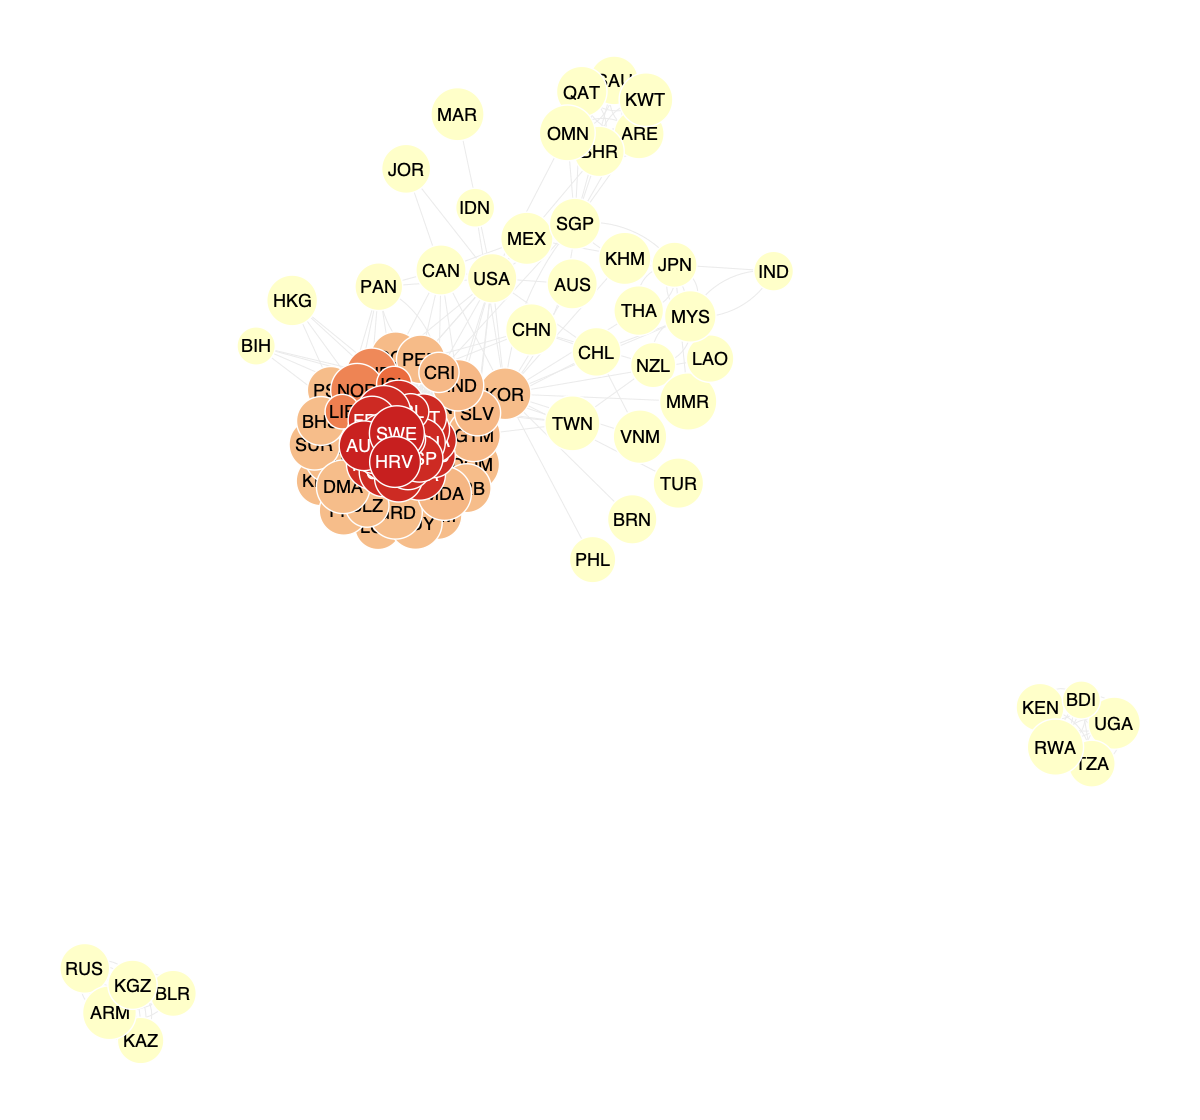

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28bf88df0, at 0x28bfab760>

In [179]:
ee, x = gt.eigenvector(sg_nonecon)

# network based on centrality
gt.graph_draw(sg_nonecon, pos=pos_scope, 
              vertex_fill_color=x,
              vertex_size=15,
              vcmap=color_map,
              vertex_text=sg_nonecon.vp.country_name,  
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              edge_color='#EBEBEB',
              vorder=x)

*Betweenness centrality*

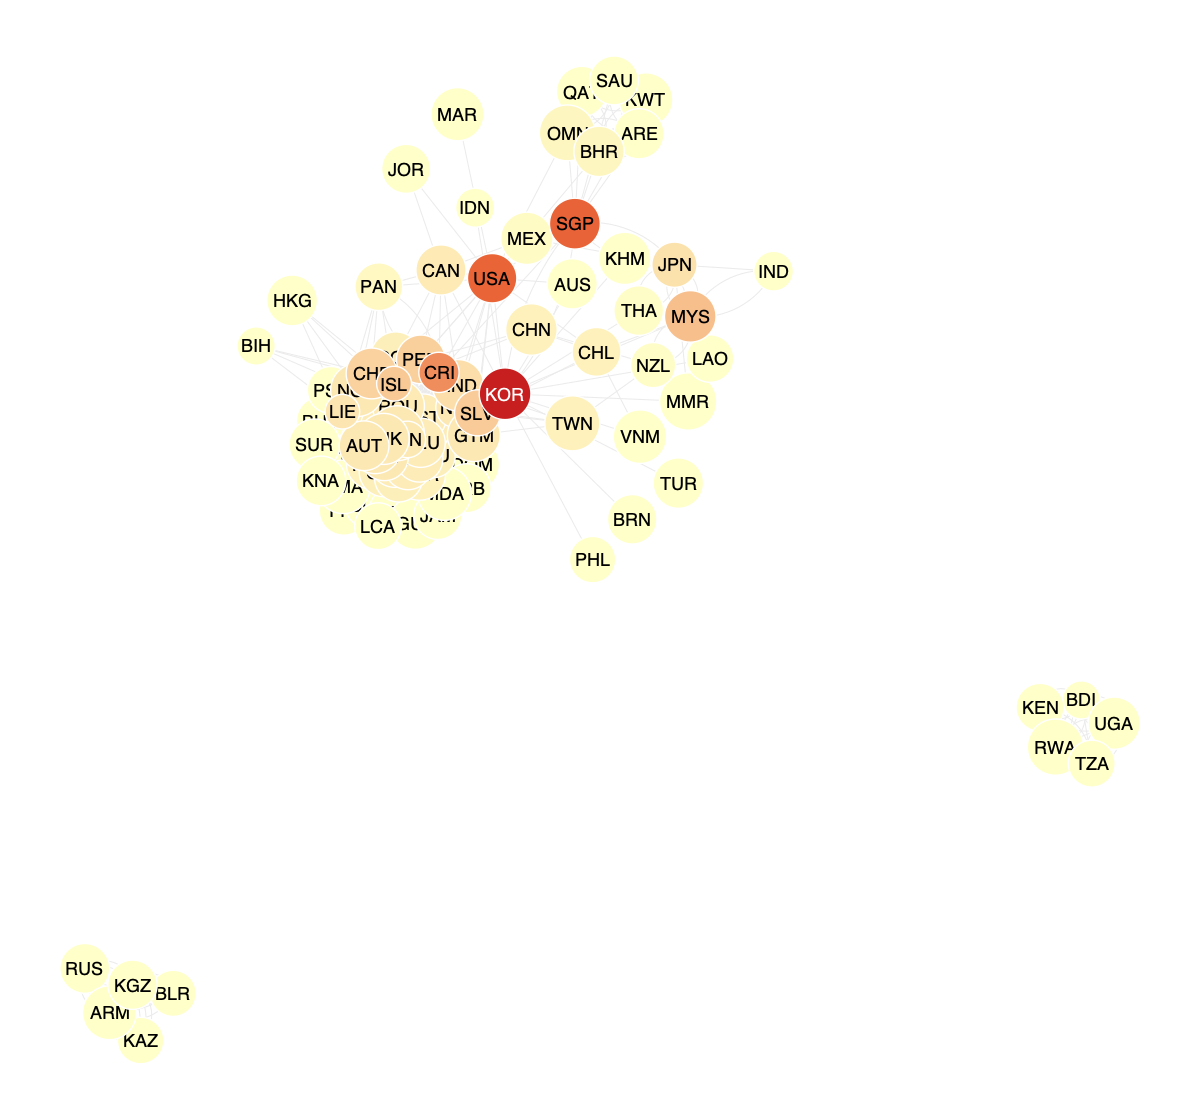

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28bf88df0, at 0x28bfab310>

In [180]:
vp, ep = gt.betweenness(sg_nonecon)
gt.graph_draw(sg_nonecon, pos=pos_scope, vertex_fill_color=vp,
              vertex_size=15,
              #edge_pen_width=gt.prop_to_size(ep, mi=0.5, ma=5),
              edge_color='#EBEBEB',
              vcmap=color_map,
              vertex_text=sg_nonecon.vp.country_name, 
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              vorder=vp)

#### iii. Agreements before 2000

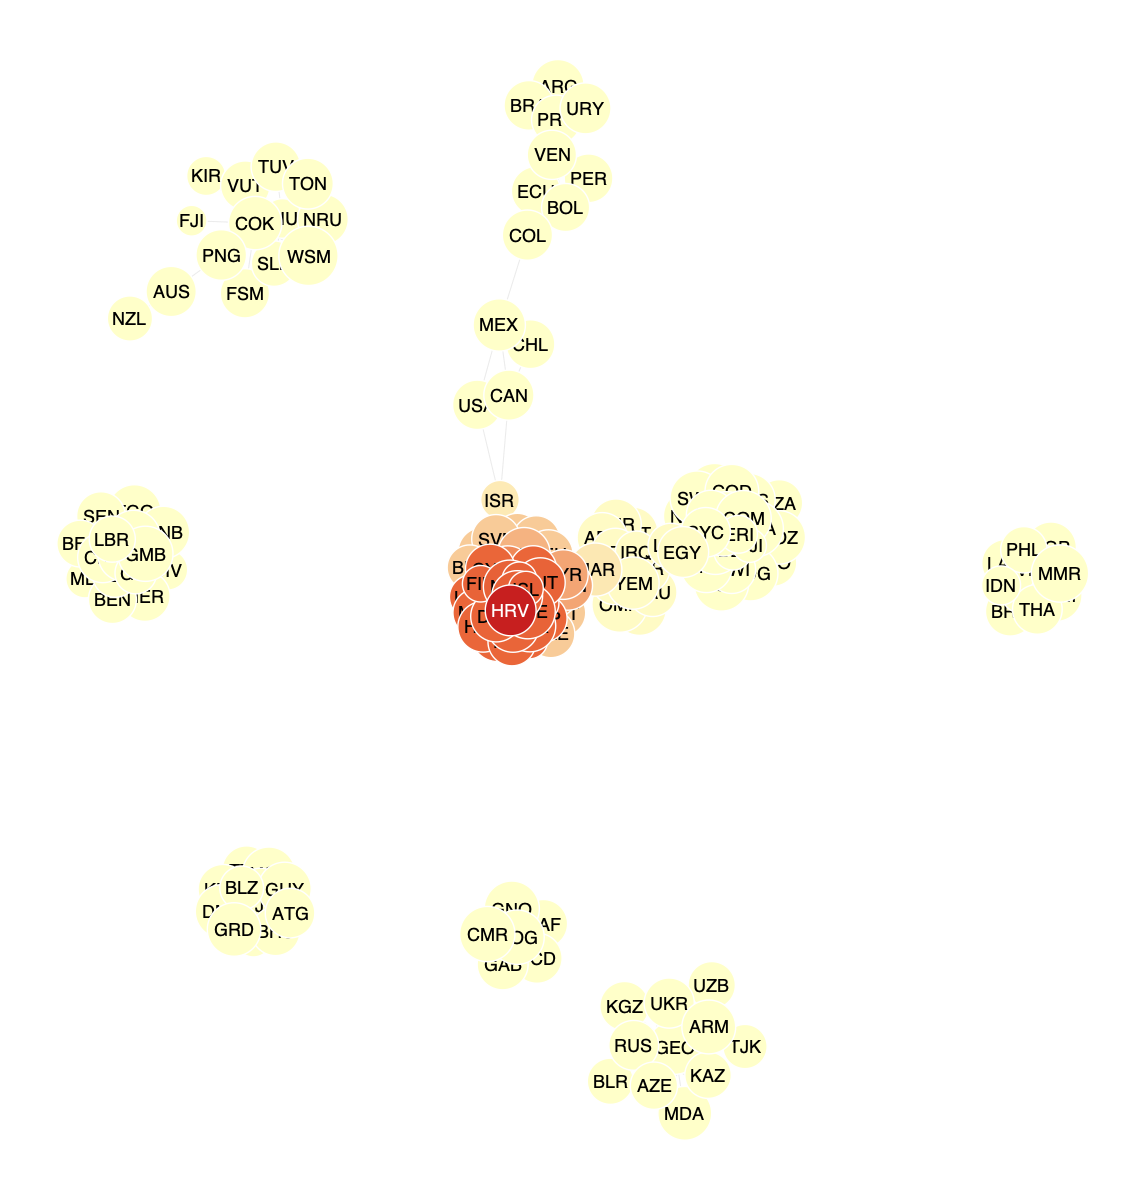

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28bf80190, at 0x28a4db100>

In [181]:
ee, x = gt.eigenvector(sg_yr1)
gt.graph_draw(sg_yr1, pos=pos_yr, 
              vertex_fill_color=x,
              vertex_size=15,
              vcmap=color_map,
              vertex_text=sg_yr1.vp.country_name,  
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              edge_color='#EBEBEB',
              vorder=x)

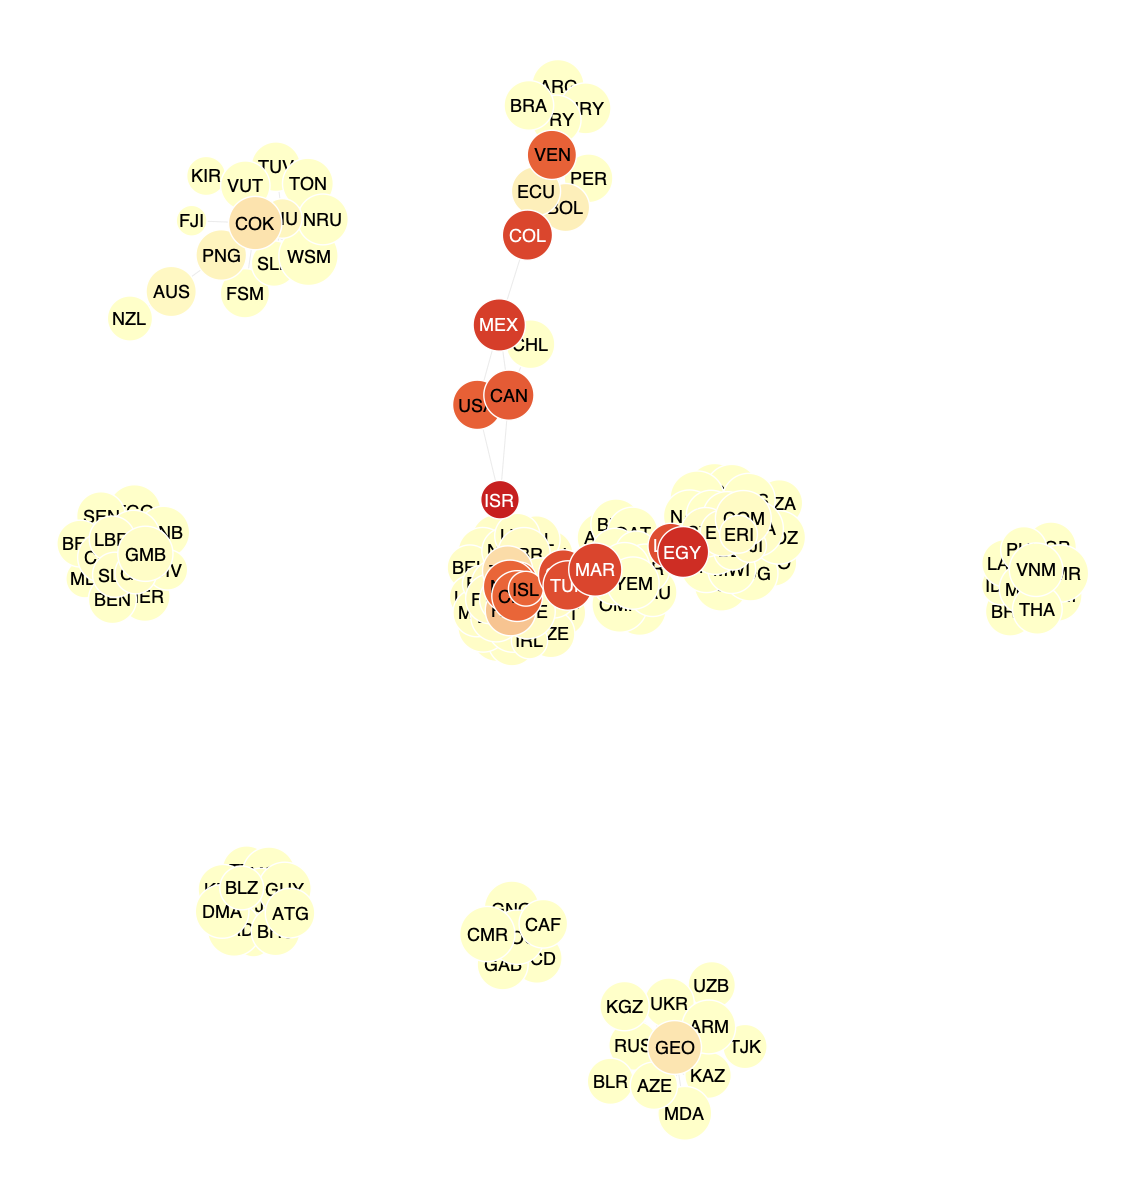

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28bf80190, at 0x28bd78d30>

In [182]:
vp, ep = gt.betweenness(sg_yr1)
gt.graph_draw(sg_yr1, pos=pos_yr, vertex_fill_color=vp,
              vertex_size=15,
              #edge_pen_width=gt.prop_to_size(ep, mi=0.5, ma=5),
              edge_color='#EBEBEB',
              vcmap=color_map,
              vertex_text=sg_yr1.vp.country_name, 
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              vorder=vp)

#### iv. Agreements after 2000

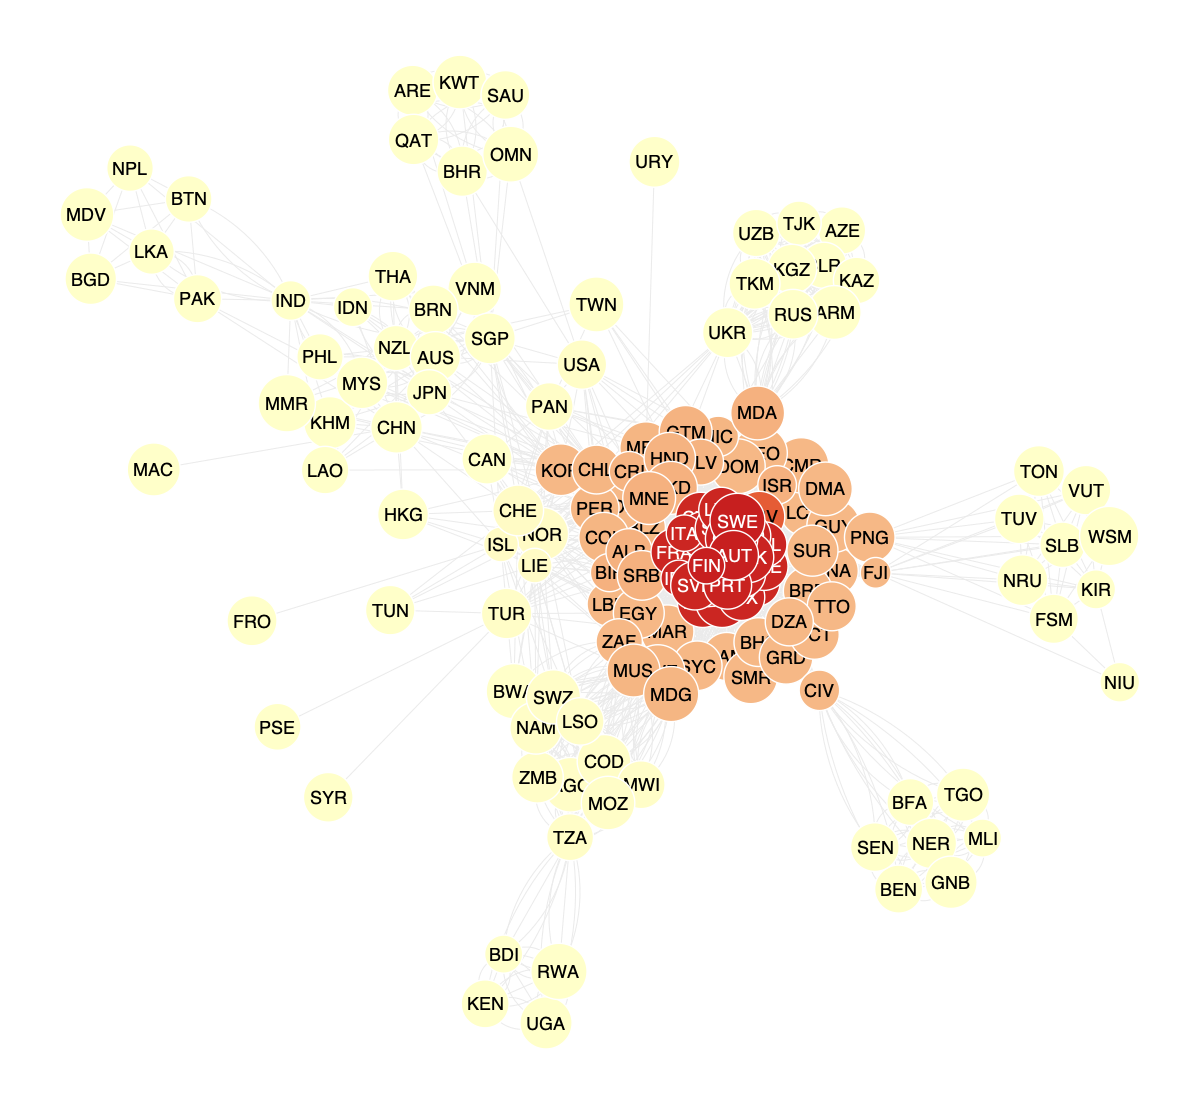

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28bf80040, at 0x287185670>

In [183]:
ee, x = gt.eigenvector(sg_yr2)
gt.graph_draw(sg_yr2, pos=pos_yr2, 
              vertex_fill_color=x,
              vertex_size=15,
              vcmap=color_map,
              vertex_text=sg_yr2.vp.country_name,  
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              edge_color='#EBEBEB',
              vorder=x)

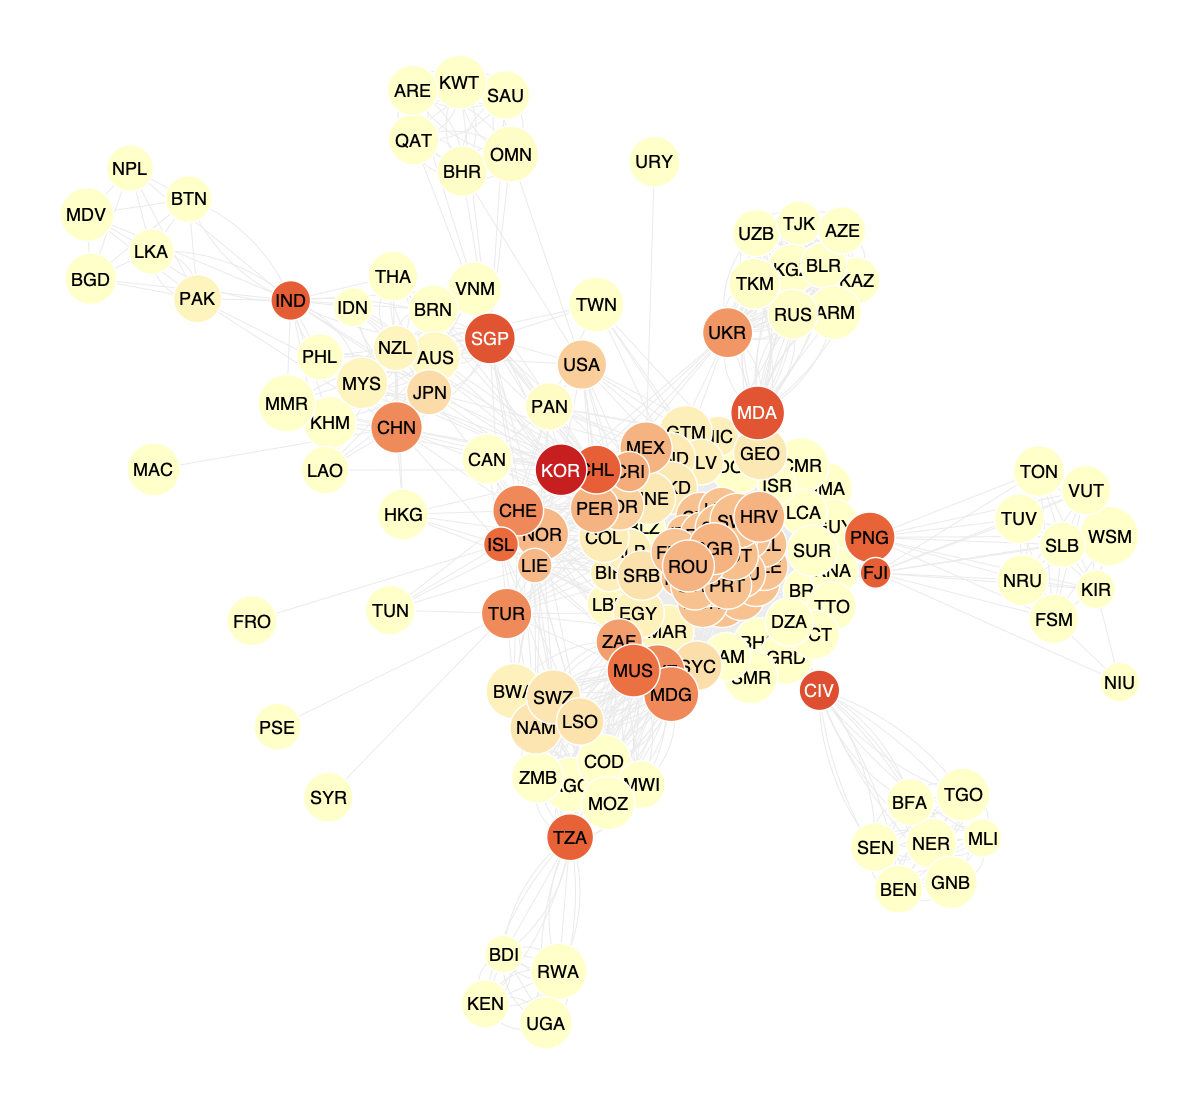

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28bf80040, at 0x28bfabd60>

In [184]:
vp, ep = gt.betweenness(sg_yr2)
gt.graph_draw(sg_yr2, pos=pos_yr2, vertex_fill_color=vp,
              vertex_size=15,
              #edge_pen_width=gt.prop_to_size(ep, mi=0.5, ma=5),
              edge_color='#EBEBEB',
              vcmap=color_map,
              vertex_text=sg_yr2.vp.country_name, 
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              vorder=vp)